In [1]:
library(Seurat)
library(data.table)
library(Matrix)
library(future)
library(dplyr)
library(tidyr)
library(patchwork)
library(ggplot2)
library(ggrepel)
library(grid)
library(Matrix)
library(doParallel)
library(FNN)
library(edgeR)
library(harmony)
library(SeuratDisk)
library(spacexr)
library(glue)
library(scales)

Registered S3 method overwritten by 'spatstat.core':
  method          from
  formula.glmmPQL MASS

Attaching SeuratObject

Warning message:
“package ‘Matrix’ was built under R version 4.1.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel

Loading required package: limma

Loading required package: Rcpp

Warning message:
“package ‘Rcpp’ was built under R version 4.1.3”
Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Warning message:
“package ‘glue’ was built under R version 4.

In [2]:
options(future.globals.maxSize = 32000 * 1024^2)
plan("multicore", workers = 12)
plan()

multicore:
- args: function (..., workers = 12, envir = parent.frame())
- tweaked: TRUE
- call: plan("multicore", workers = 12)

In [3]:
if (file.exists("data/cosmx_RLN.rds")) {
    nano.obj <- readRDS("data/cosmx_RLN.rds")
} else {
    nano.objs <- list()
    for (slide in c(1, 2, 3)) {
        nano.obj <- LoadNanostring(data.dir = paste0("data/Slide", slide), fov = "Slide")

        meta.data <- read.csv(paste0("data/Slide", slide, "/SMI-0026_Slide", slide, "_metadata_file.csv"))
        meta.data$id <- paste0(meta.data$cell_ID, "_", meta.data$fov)
        rownames(meta.data) <- meta.data$id
        meta.data <- cbind(meta.data[rownames(nano.obj@meta.data),], nano.obj@meta.data)
        nano.obj <- AddMetaData(nano.obj, metadata = meta.data)
        
        nano.obj@meta.data$slide = slide

        nano.obj@meta.data$patient = 2 * (slide - 1) + 1
        nano.obj@meta.data$patient[nano.obj@meta.data$CenterX_global_px < 0] = 2 * (slide - 1) + 2
        
        nano.obj$cell_filtering <- "remove"
        for(patient_id in unique(nano.obj@meta.data$patient)) {
            meta_sub <- nano.obj@meta.data[nano.obj$patient == patient_id,]
            nCount_Nanostring_low = as.numeric(quantile(meta_sub$nCount_Nanostring, prob=c(0.2)))
            print(paste0("Patient ", patient_id, " nCount_Nanostring > ", nCount_Nanostring_low))
            meta_sub <- meta_sub[meta_sub$nCount_Nanostring > nCount_Nanostring_low,]
            nano.obj$cell_filtering[colnames(nano.obj) %in% rownames(meta_sub)] <- "keep"
        }
        nano.obj <- subset(nano.obj, cell_filtering == "keep")

        nano.objs[[slide]] <- nano.obj
    }

    nano.obj <- merge(nano.objs[[1]], y = c(nano.objs[[2]], nano.objs[[3]]), 
                      add.cell.ids = c("1", "2", "3"), project = "cHL_spatial")
    
    print(dim(nano.obj))
    
    nano.obj@images$Slide_1 <- NULL
    nano.obj@images$Slide_2 <- NULL
    nano.obj@images$Slide_3 <- NULL

    nano.obj[['Slide_1']] <- nano.obj[['Slide']]
    nano.obj[['Slide']] <- NULL
    
    nano.obj@meta.data$patient.fov <- paste0(nano.obj@meta.data$patient, ".", nano.obj@meta.data$fov)
    nano.obj@meta.data$condition <- "Lymph Node"
    nano.obj@meta.data$condition[nano.obj@meta.data$patient %in% c("2", "4","5","6")] <- "cHL"
    
    nano.obj <- subset(nano.obj, condition == 'Lymph Node')
    nano.obj@meta.data$slide.fov <- paste0(nano.obj@meta.data$slide, ".", nano.obj@meta.data$fov)
        
    nano.obj <- SCTransform(nano.obj, assay = "Nanostring", clip.range = c(-10, 10), verbose = FALSE)
    
    
    DefaultAssay(nano.obj) <- "SCT"
    
    VariableFeatures(nano.obj) <- rownames(nano.obj) # use all features, we have few to begin withj)
    nano.obj <- RunPCA(nano.obj, npcs = 50, features = rownames(nano.obj))
    nano.obj <- RunHarmony(nano.obj, "slide.fov", assay.use="SCT")
    nano.obj <- RunUMAP(nano.obj, reduction='harmony', dims = 1:50, spread=5)
    nano.obj <- FindNeighbors(nano.obj, reduction='harmony', dims = 1:10)
    nano.obj <- FindClusters(nano.obj, resolution = 0.5)
    
    markers <- read.csv("data/hrs_markers.csv")$x[read.csv("data/hrs_markers.csv")$x 
                                              %in% rownames(nano.obj@assays$Nanostring@counts)]
    markers <- c(markers, 'NFKBIA', 'STAT5A', 'IL6', 'CDKN1A', 'IER3','CD274')
    nano.obj@meta.data$hrs.markers.sum <- colSums(nano.obj@assays$Nanostring@counts[markers, ])
    
    doublet.RCTDs <- lapply(paste0("data/RCTD_cosmx_patient_", unique(nano.obj@meta.data$patient),".rds"), function(s) readRDS(s)@results$results_df)
    doublet.RCTD <- do.call(rbind.data.frame, doublet.RCTDs)
    doublet.RCTD <- doublet.RCTD[rownames(nano.obj@meta.data),]
    nano.obj <- AddMetaData(nano.obj, metadata = doublet.RCTD)
                            
    saveRDS(nano.obj, "data/cosmx_RLN.rds")

}
nano.obj

An object of class Seurat 
1956 features across 193025 samples within 2 assays 
Active assay: SCT (978 features, 978 variable features)
 1 other assay present: Nanostring
 3 dimensional reductions calculated: pca, harmony, umap

### Load Seurat Integrated Slides

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


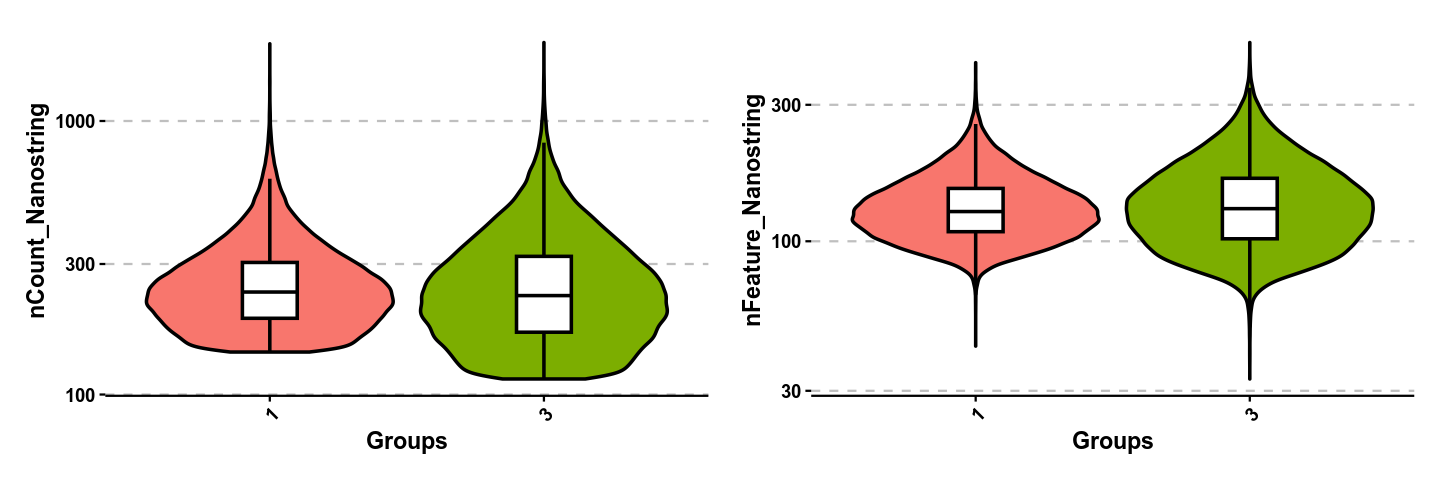

In [8]:
options(repr.plot.width=12, repr.plot.height=4)
colors <- hue_pal()(4)
names(colors) <- unique(nano.obj[['patient']])$patient
p1 <- SCpubr::do_ViolinPlot(sample = nano.obj, 
                        feature = c("nCount_Nanostring"), group.by = "patient",colors.use=as.list(colors)) + scale_y_continuous(trans='log10')
p2 <- SCpubr::do_ViolinPlot(sample = nano.obj, 
                        feature = c("nFeature_Nanostring"), group.by = "patient", colors.use=as.list(colors)) + scale_y_continuous(trans='log10')
p1 | p2

In [ ]:
nano.obj <- RunUMAP(
    nano.obj, reduction='harmony', dims = 1:50, 
    spread=10, min.dist = 0.01, learning.rate=10, n.neighbors = 15L, n.epochs=1000
)

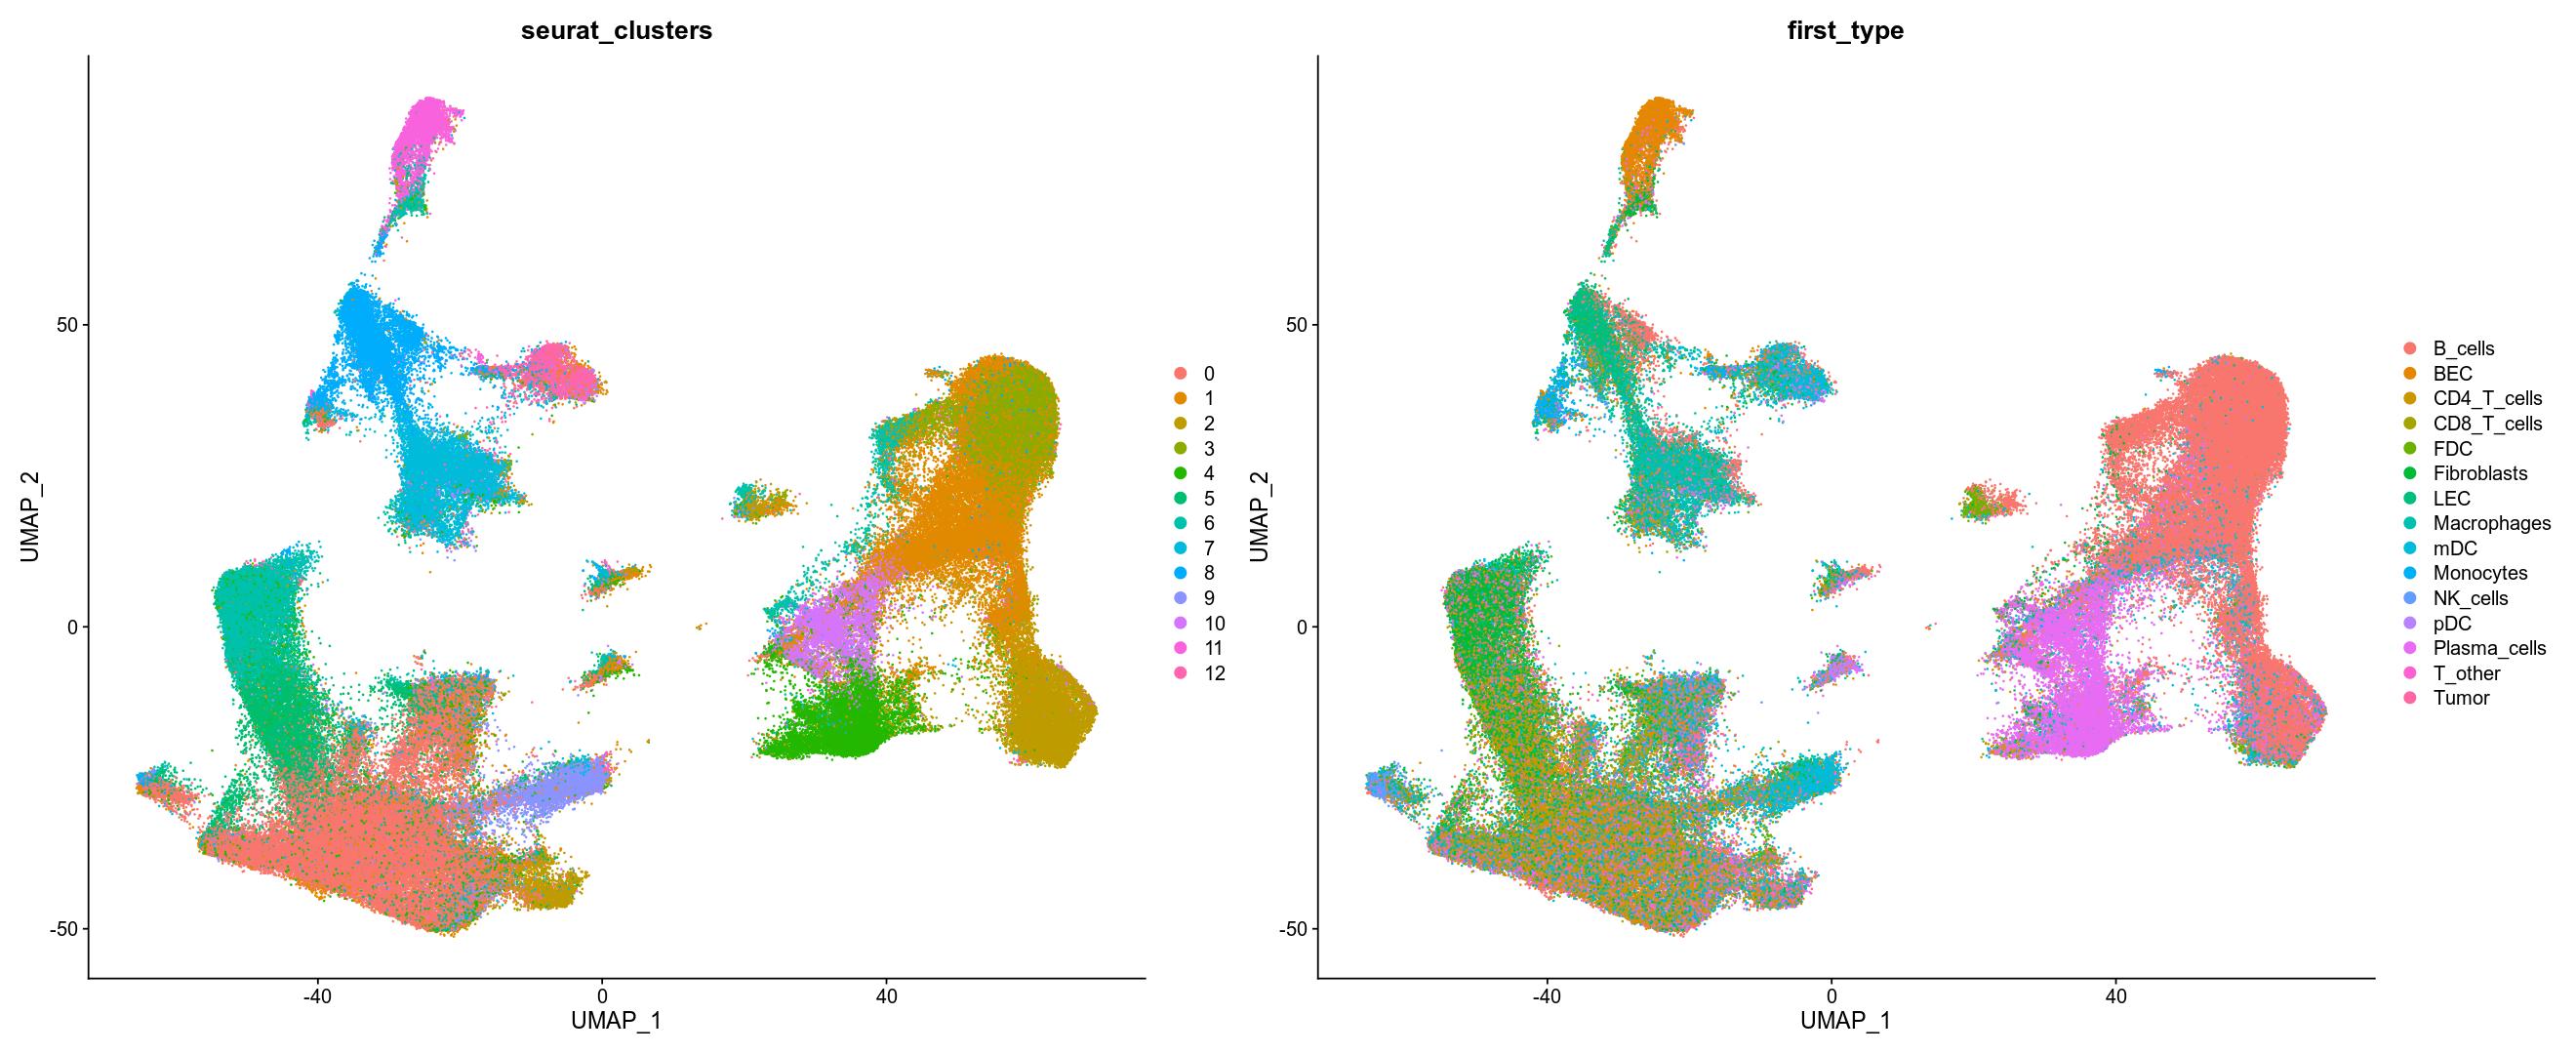

In [31]:
options(repr.plot.width=22, repr.plot.height=9)
p1 <- DimPlot(nano.obj, reduction = "umap", group.by = c("seurat_clusters"), pt.size=0.1, shuffle=FALSE,raster=FALSE)
p2 <- DimPlot(nano.obj, reduction = "umap", group.by = c("first_type"), pt.size=0.1, shuffle=FALSE,raster=FALSE)
p1 | p2 

### Save

In [36]:
nano.obj@images$Slide_1 <- NULL
nano.obj@images$Slide_2 <- NULL
nano.obj@images$Slide_3 <- NULL

In [38]:
saveRDS(nano.obj, "data/cosmx_RLN.rds")

In [ ]:
SaveH5Seurat(nano.obj, "data/cosmx_RLN.h5Seurat", overwrite = TRUE)

In [ ]:
Convert("data/cosmx_RLN.h5Seurat", dest = "h5ad", overwrite=TRUE)

In [242]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Debian GNU/Linux 11 (bullseye)

Matrix products: default
BLAS/LAPACK: /home/dchafamo/anaconda3/envs/muscat2/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] parallel  grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] spacexr_2.0.7         SeuratDisk_0.0.0.9020 harmony_0.1.1        
 [4] Rcpp_1.0.9            edgeR_3.36.0          limma_3.50.3         
 [7] FNN_1.1.3.1           doParallel_1.0.17     iterators_1.0.14     
[10] foreach_1.5.2         ggrepel_0.9.2         ggplot2_3.4.0        
[13] patchwork_1.1.2       tidyr_1.2.1  